# Books Recommender Engine: Data Cleaning and EDA Part 2

Reference to notebook #2. 

### Contents:
- [Imports](#Imports)
- [Reading in the Data](#Reading-in-the-Data)
- [Preliminary Exploratory Data Analysis](#Preliminary-Exploratory-Data-Analysis)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Saving the DataFrame](#Saving-the-DataFrame)

## Imports

In [156]:
#importing in the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import regex as re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

%config InlineBackend.figure_format = 'retina'

## Reading in the Data

Info about the dataset here

In [157]:
#reading in the data
goodreads = pd.read_csv('./datasets/goodreads.csv')
goodreads.head()

,author_average_rating,author_gender,author_genres,author_id,author_name,author_page_url,author_rating_count,author_review_count,birthplace,book_average_rating,book_fullurl,book_id,book_title,genre_1,genre_2,num_ratings,num_reviews,pages,publish_date,score
0,3.93,male,"christian,philosophy,religion,",6819578,Augustine of Hippo\n,/author/show/6819578.Augustine_of_Hippo,56672,2845,Algeria\n,3.90,https://www.goodreads.com/book/show/27037.Conf...,27037,\n The Confessions of St. Augustine\n,Philosophy,Classics,38803,1886,0,397,604
1,4.05,male,"children-s-books,science-fiction-fantasy,relig...",2413,George MacDonald\n,/author/show/2413.George_MacDonald,84443,5868,Scotland\n,4.01,https://www.goodreads.com/book/show/179579.The...,179579,\n The Light Princess\n,Fantasy,Classics,5950,384,0,1864,1149
2,4.01,male,"children-s-books,travel,",45306,Karl May\n,/author/show/45306.Karl_May,28502,614,Germany\n,4.14,https://www.goodreads.com/book/show/1612379.Wi...,1612379,\n Winnetou I\n,Fiction,Adventure,3664,154,0,1892,1366
3,3.91,female,"children-s-books,mystery-thrillers,young-adult,",6001,Carolyn Keene\n,/author/show/6001.Carolyn_Keene,574501,17566,\n,4.24,https://www.goodreads.com/book/show/32974.Nanc...,32974,\n Nancy Drew: #1-6 [Box Set]\n,Mystery,Young Adult,2883,108,0,1930,2937
4,4.14,male,"christian,religion,",1069006,C.S. Lewis\n,/author/show/1069006.C_S_Lewis,5029410,112009,Ireland\n,4.12,https://www.goodreads.com/book/show/30628.Spac...,30628,\n Space Trilogy: Out of the Silent Plane...,Science Fiction,Fiction,8258,358,0,1938,1706


## Preliminary Exploratory Data Analysis

In [158]:
#I know I won't need some of these columns, so I'm going to go ahead and drop them 
goodreads.drop(['author_page_url', 'book_fullurl', 'author_gender', 'author_genres', 'author_average_rating', 'author_id', 'birthplace', 'author_rating_count', 'author_review_count', 'book_id'], 1,  inplace=True)

In [159]:
# Looking at how large the file is
goodreads.shape

(22678, 10)

In [160]:
#taking a look at the user file types
goodreads.dtypes

author_name             object
book_average_rating    float64
book_title              object
genre_1                 object
genre_2                 object
num_ratings              int64
num_reviews              int64
pages                    int64
publish_date             int64
score                    int64
dtype: object

In [161]:
#Looking for nulls
goodreads.isnull().sum()

author_name            0
book_average_rating    0
book_title             0
genre_1                0
genre_2                0
num_ratings            0
num_reviews            0
pages                  0
publish_date           0
score                  0
dtype: int64

In [162]:
#initial look at the numbers num_ratings looks like it may have some anomolies, stds look pretty large 
#for num_reviews and score, also noting that year doesn't show up. Must be text in that column somewhere.
goodreads.describe()

,book_average_rating,num_ratings,num_reviews,pages,publish_date,score
count,22678.000000,2.267800e+04,22678.000000,22678.000000,22678.000000,22678.000000
mean,3.951732,4.676406e+04,2327.537966,332.930990,1935.191904,3872.682953
std,0.290897,1.800386e+05,6835.540664,218.542768,352.900758,10951.091304
min,0.000000,0.000000e+00,0.000000,0.000000,-720.000000,55.000000
25%,3.770000,8.280000e+02,106.000000,238.000000,1998.000000,832.000000
50%,3.960000,4.441500e+03,386.000000,315.000000,2011.000000,1724.000000
75%,4.140000,2.036750e+04,1508.000000,384.000000,2013.000000,3590.500000
max,5.000000,3.820921e+06,147696.000000,6680.000000,2019.000000,598270.000000


## Data Cleaning

In [163]:
#dropping duplicates
goodreads = goodreads.drop_duplicates()

In [166]:
#I noticed new row markers (\n) in the book title column so let's remove those
goodreads['book_title'] = goodreads['book_title'].map(lambda cell: cell.replace("\n"," "))

In [167]:
#the author column has the new row markers too so I'm removing them:
goodreads['author_name'] = goodreads['author_name'].map(lambda cell: cell.replace("\n"," "))

In [168]:
#taking a look at the year column more closely because I saw negatives in the summary stats
goodreads['publish_date'].sort_values(ascending=True).head()

21942   -720
21092   -720
21093   -720
21943   -720
17594   -600
Name: publish_date, dtype: int64

There are a lot of incorrect year listings. I'm going to take a sample of the dataset and pull everything from 1800 and upward, and I'm including years back that far because it looks like they are listing first year publication.

In [169]:
#pulling a sample set based on the year being 1900 and above. 
goodreads_sample = goodreads[goodreads['publish_date'] >= 1900]

In [170]:
#checking the size to see how many rows we lost and it looks like we lost just over 1k.
goodreads_sample.shape

(21487, 10)

In [171]:
goodreads_sample['genre_1'].value_counts()

Romance                    3271
Fantasy                    3255
Young Adult                2434
Fiction                    2081
Historical                 1370
Nonfiction                  943
Science Fiction             938
Mystery                     799
Sequential Art              628
Horror                      508
Childrens                   413
History                     387
Paranormal                  328
New Adult                   324
Classics                    317
Poetry                      220
Erotica                     189
Thriller                    159
Biography                   156
Dark                        152
Short Stories               151
Christian Fiction           139
Novels                      118
Adult Fiction               113
Humor                       102
Contemporary                101
Lgbt                         99
Religion                     97
Womens Fiction               93
Autobiography                92
                           ... 
European

## Further Exploratory Data Analysis

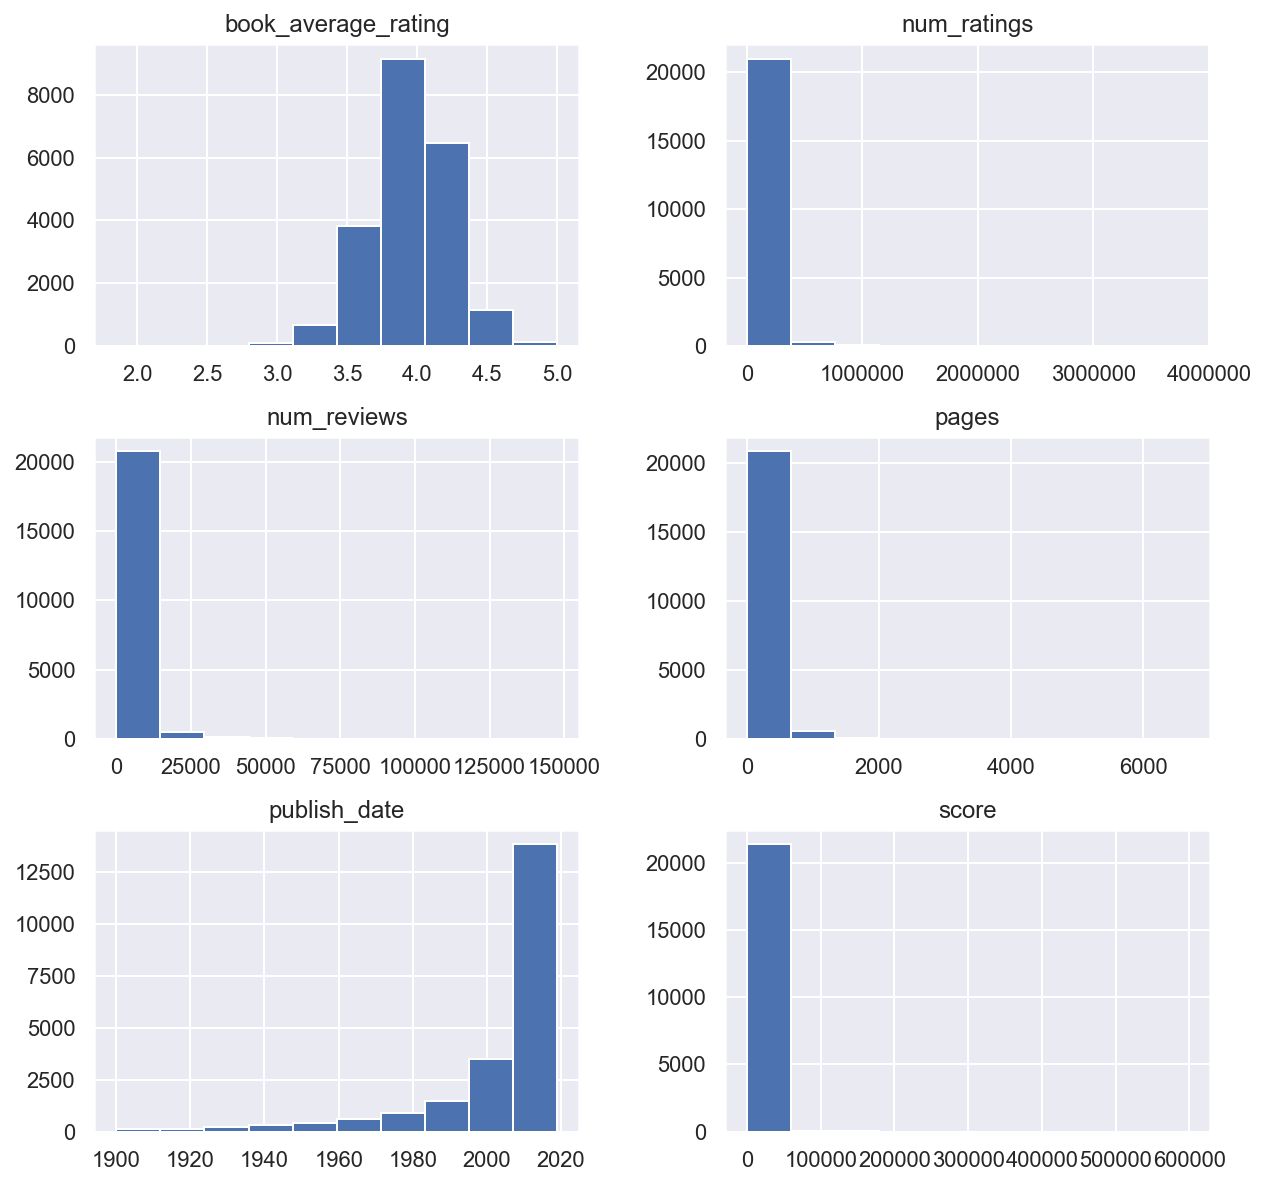

In [172]:
#checking out the numeric columns
goodreads_sample.hist(figsize=(10,10));

## Saving the DataFrame

In [173]:
#saving the sample dataframe to a csv
goodreads_sample.to_csv('./datasets/goodreads_sample.csv')